In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy.random as npr
import logistic_svd.numba_version

import matplotlib.pylab as plt
%matplotlib inline

# 1d factor model

In [2]:
# generate some simulated data
Nc=1000
Ng=40
Nk=1
z=npr.randn(Nc,Nk)
alpha=npr.randn(Ng,Nk)
data = npr.rand(Nc,Ng) < (1 / (1+np.exp(-z@alpha.T)))

# fit model to simulated data
z_guess,alpha_guess,likelihoods=logistic_svd.numba_version.train(Nk,10,binary_matrix=data,approx=True)

# for comparison with the truth,
# use the true parameters to
# flip our estimates to the right sign
# (this orientation is not identifiable)
if np.sum(alpha_guess*alpha)<0:
    alpha_guess=-alpha_guess
    z_guess=-z_guess

out of 10: 
0 1 2 3 4 5 6 7 8 9 ...done


Text(0.5,1,'z estimates')

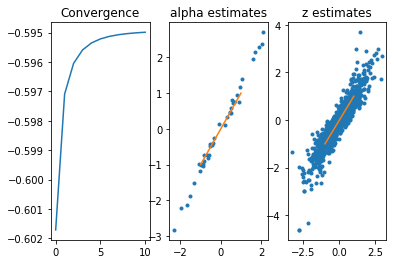

In [3]:
plt.subplot(1,3,1)
plt.plot(likelihoods)
plt.title("Convergence")


plt.subplot(1,3,2)
plt.plot(alpha,alpha_guess,'.')
plt.plot([-1,1],[-1,1])
plt.title("alpha estimates")

plt.subplot(1,3,3)
plt.plot(z,z_guess,'.')
plt.plot([-1,1],[-1,1])
plt.title("z estimates")


# bigger model

In [4]:
# simulated data
Nc=1000
Ng=4000
Nk=10
z=npr.randn(Nc,Nk)
alpha=npr.randn(Ng,Nk)
data = npr.rand(Nc,Ng) < (1 / (1+np.exp(-z@alpha.T)))

# fit model to data
z_guess,alpha_guess,likelihoods=logistic_svd.numba_version.train(Nk,10,binary_matrix=data)

out of 10: 
0 1 2 3 4 5 6 7 8 9 ...done


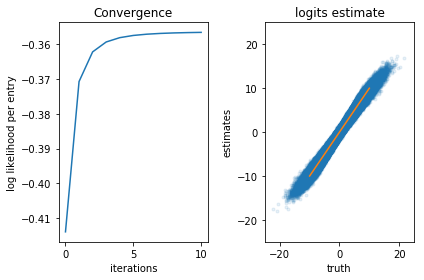

In [5]:
plt.subplot(1,2,1)
plt.plot(likelihoods)
plt.title("Convergence")
plt.xlabel("iterations")
plt.ylabel("log likelihood per entry")

plt.subplot(1,2,2)
plt.plot((z@alpha.T).ravel(),(z_guess@alpha_guess.T).ravel(),'.',alpha=.1)
plt.ylabel('estimates')
plt.xlabel("truth")
plt.plot([-10,10],[-10,10])
plt.title("logits estimate")
plt.xlim(-25,25)
plt.ylim(-25,25)

plt.tight_layout()

# using lower-level functions

In [8]:
# simulated data
Nc=1000
Ng=4000
Nk=10
z=npr.randn(Nc,Nk)
alpha=npr.randn(Ng,Nk)
data = npr.rand(Nc,Ng)< (1 / (1+np.exp(-z@alpha.T)))
dmhalf=data-.5

In [11]:
# SVD for initial conditions
import scipy.sparse.linalg
U,e,V = scipy.sparse.linalg.svds(dmhalf,Nk)

z_guess=U@np.diag(e)
alpha_guess=V.T
logits=z@alpha.T
alpha_guess2=logistic_svd.numba_version.update_alpha(dmhalf,z_guess,alpha_guess,0)

print("likelihood under true model\t\t",logistic_svd.numba_version.likelihood(dmhalf,z,alpha))
print("initial likelihood\t\t\t",logistic_svd.numba_version.likelihood(dmhalf,z_guess,alpha_guess))

alpha_guess2=logistic_svd.numba_version.update_alpha(dmhalf,z_guess,alpha_guess,0)
print("likelihood after updating alpha\t\t",logistic_svd.numba_version.likelihood(dmhalf,z_guess,alpha_guess2))

z_guess2=logistic_svd.numba_version.update_z(dmhalf,z_guess,alpha_guess2,0)
print("likelihood after updating alpha and z\t",logistic_svd.numba_version.likelihood(dmhalf,z_guess2,alpha_guess2))


likelihood under true model		 -0.361890452477623
initial likelihood			 -0.586152345502795
likelihood after updating alpha		 -0.41035929210575645
likelihood after updating alpha and z	 -0.3809995936563908


# inspecting the minorization we use

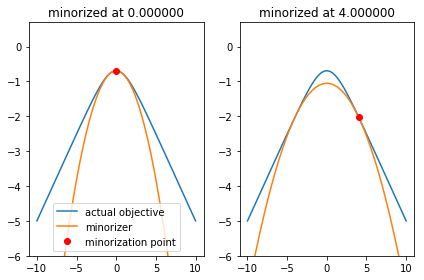

In [25]:
plt.subplot(1,2,1)
xs=np.r_[-10:10:100j]
plt.plot(xs,-np.log(2*np.cosh(xs/2)),label='actual objective')
x0=0
M,k=logistic_svd.numba_version.calc_minorizer(x0)
plt.plot(xs,k-.5*M*xs**2,label='minorizer')
plt.plot([x0],[-np.log(2*np.cosh(x0/2))],'ro',label='minorization point')
plt.legend()
plt.ylim(-6,np.log(2))

plt.title('minorized at %f'%x0)
    
    
plt.subplot(1,2,2)
plt.plot(xs,-np.log(2*np.cosh(xs/2)))
x0=4
M,k=logistic_svd.numba_version.calc_minorizer(x0)
plt.plot(xs,k-.5*M*xs**2)
plt.plot([x0],[-np.log(2*np.cosh(x0/2))],'ro')
plt.ylim(-6,np.log(2))

plt.title('minorized at %f'%x0)

plt.tight_layout()